In [2194]:
from scipy.io import wavfile
from IPython.display import Audio, display
import pywt
from scipy.fftpack import dct, idct, fft, ifft
from scipy.signal import correlate
import numpy as np
import pandas as pd

In [2195]:
file_name = './payload.wav'

In [2196]:
rate, data = wavfile.read(file_name)
print("rate: ", rate)
display(Audio(data, rate=rate))

FileNotFoundError: [Errno 2] No such file or directory: './payload.wav'

In [2197]:
# time domain statistics (describe the signal)

data_series = pd.Series(data)
data_series.describe()




count    548646.000000
mean          0.000021
std           0.302570
min          -1.295844
25%          -0.128880
50%           0.001107
75%           0.201477
max           1.000000
dtype: float64

In [2198]:
data = data / data.max()
display(Audio(data, rate=rate))

In [2199]:
message = "xianyue"
message_bits = ''.join([format(ord(c), '08b') for c in message])
message_bits

'01111000011010010110000101101110011110010111010101100101'

In [2200]:
(cA, cD) = pywt.dwt(data, 'db1')

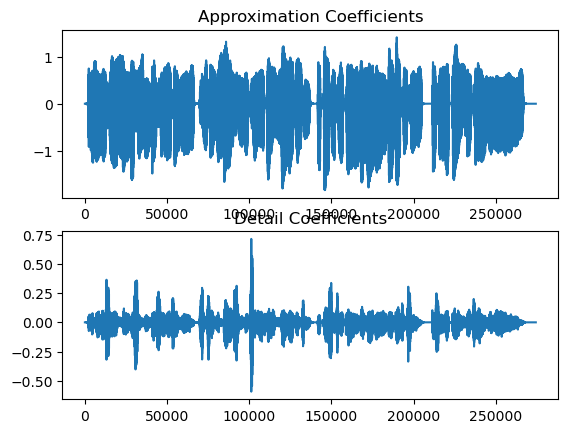

In [2201]:
# draw the wavelet transform
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(cA)
plt.title("Approximation Coefficients")
plt.subplot(2, 1, 2)
plt.plot(cD)
plt.title("Detail Coefficients")
plt.show()


In [2202]:
# base
display(Audio(cA, rate=rate / 2))

In [2203]:
# detail
display(Audio(cD, rate=rate / 2))

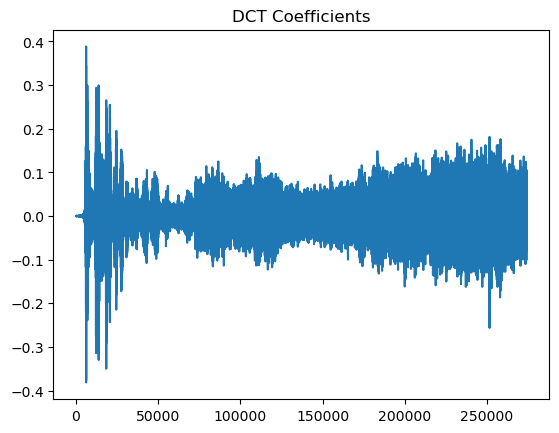

In [2204]:
dctcoef = dct(cD, norm='ortho')
# draw the dct
plt.figure()
plt.plot(dctcoef)
plt.title("DCT Coefficients")
plt.show()

In [2205]:
alpha = 0.3 * (dctcoef.max() - dctcoef.min())
watermarked_payload = dctcoef.copy()



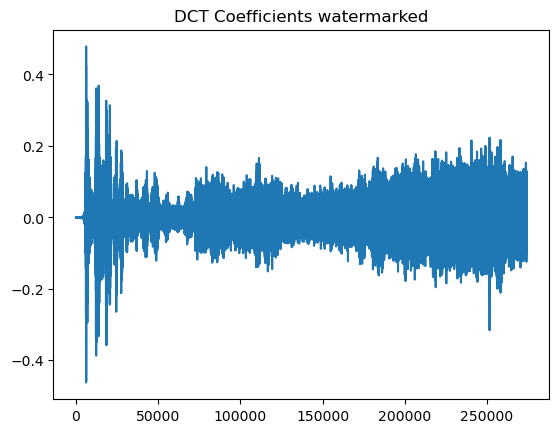

In [2206]:
wm_inx = 0
for i in range(watermarked_payload.size):
    if watermarked_payload[i] == 0:
        continue
    watermarked_payload[i] += alpha * int(message_bits[wm_inx]) * dctcoef[i]
    wm_inx = (wm_inx + 1) % len(message_bits)
plt.figure()
plt.plot(watermarked_payload)
plt.title("DCT Coefficients watermarked")
plt.show()

In [2207]:
# icdt

watermarked_cD = idct(watermarked_payload, norm='ortho')
display(Audio(watermarked_cD, rate=rate / 2))

In [2217]:
watermarked_data = pywt.idwt(cA, watermarked_cD, 'db1')
display(Audio(watermarked_data, rate=rate))
#output_file_path = './audio_example/alpha_03_cD.wav'
#wavfile.write(output_file_path, rate, watermarked_data)

In [2209]:
# add some noise to the watermarked data
watermarked_data_altered = watermarked_data + np.random.normal(0, 0.0005, watermarked_data.size)
display(Audio(watermarked_data_altered, rate=rate))


In [2210]:
watermarked_data = watermarked_data_altered

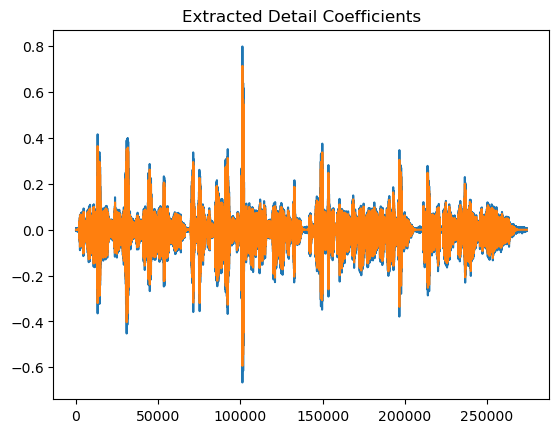

In [2211]:
# extract the watermark
watermarked_data = watermarked_data / watermarked_data.max()
extracted_cA, extracted_cD = pywt.dwt(watermarked_data, 'db1')


plt.figure()
plt.plot(extracted_cD)
plt.plot(cD)
plt.title("Extracted Detail Coefficients")


plt.show()



<Figure size 640x480 with 0 Axes>

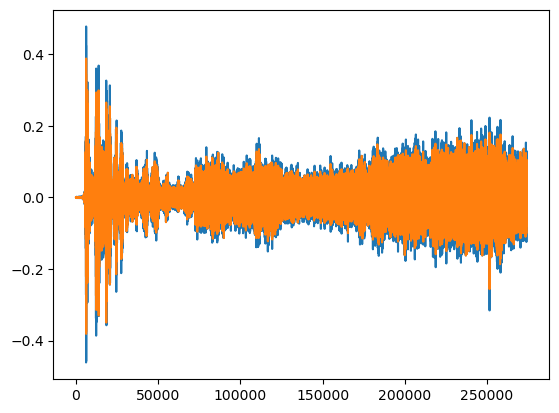

<Figure size 640x480 with 0 Axes>

In [2212]:
extracted_dct = dct(extracted_cD, norm='ortho')
plt.plot(extracted_dct)
plt.plot(dctcoef)
plt.figure()

In [2213]:
extracted_message_bits = np.zeros(watermarked_payload.size)
for i in range(watermarked_payload.size):
    if abs(extracted_cD[i]) <= 1e-6:
        continue
    extracted_message_bits[i] = (extracted_dct[i] - dctcoef[i]) / alpha / dctcoef[i]
    
# z normalize
extracted_message_bits = (extracted_message_bits - extracted_message_bits.mean()) / extracted_message_bits.std()
extracted_message_bits = (extracted_message_bits > 0).astype(int)


extracted_message = ''.join([chr(int(''.join([str(int(x)) for x in extracted_message_bits[i:i+8]]), 2)) for i in range(0, len(extracted_message_bits), 8)])
extracted_message

'!õl\x93:¹îFÞ\x82æP\nz¯i\x93Ýï;¡öÐ(>»hs\x99Þ=\x87\x15\x9aÁ\x99Ì\x89\x1e!\x8b+4\t&\x05\x82æ\nï÷?bßß\x15ÎÚ)æ\x9f¶iP»½O¬j£Y\'{¾É\x0eÂ\\]Ò>÷*ö`*!Û\x06«M5éä½EmA£ñ:ÄÂD]Bl\x10oÈåª\tÝ\x8a\x9fÙ\nÏ\t\x04\x899a\x9dóºtÇpð\x16\'E»&A§=GÇµ\x9bY¤\'O\x08\x9c\x00w\x1a¤7\x03\x06àM\x86Z¥\x96Y$ÌÖ\x7fýÂÙEí\x11\th+\x98jg9.ñRYóÝÇ£÷n»\x1c¢¢|R/\x0eF¯°Fç\x9fh\x8eY\x9c\xadéá§\x17 °f\x82~µO\x1bë1\x7fuL£þ.&J\nOaN¸\x0bCÜÁ\x9bÊ\x08Þ\x1cby~èó"¯YoMMv\x1fú3\x17_-kÞI\x006ã¶vø:ú£Ò\x08ÈL1³«B½ÞÁüÚ\x17¹\x05\x10!ªwè¥XÝ\x00i~©í\x97\x19\x7fE<Û¸|»Ag>°Èeç13\x915O\x0cÂª%\x07\\\x0e\x15(T\x8c2Ü\'»Ë|?\x988-¿û\x00\x89íî|µíà0w\x08\x1f!\x92ó5\x1cî\xa0\x82Z\x11nÉB\x97üå\x8eÉ´Yu\x1f0©\x90Ñ\x88I¦QV\x91öuªq¨iP-§9\x13xÚªºF\x07\x86:\x92Æ\x97`ñw?ÆáiO*r`\x8f\x84\t\x1b\x90Ò\x9bm¦o6]\x90[XA\x1dT\x03v{\x87ËrÀ÷n¤\x88îñ<a\x8feýmªÐ=vb\x14±[\x0c%ìOM\x90ø_2SNRm\x90\x05@Þh\\eT]m~ÛQe\x16\tØRÈï^\x10l\x01J\\¦¦ëaø*ë\x0f|É\x14q-\x85\x05%¸\xadLêäâu²Õ-ûÔJé-@WÔbzuÉPX\x8a\r/T³D*\x04Paâ}*&Þ§um+ã3nêD\x08`!B\x86¹\x01\tQ,a·9óUZmad\x89QY0A \x89É1@pèÈbjD $¹!l¹0d8(aâ¸S

In [2214]:
autocorr = correlate(extracted_message_bits, extracted_message_bits, mode='full')
autocorr = autocorr[len(autocorr) // 2:]
period = np.argmax(autocorr[1:]) + 1 

period

56

In [2215]:
# majority vote
extracted_message_bits_x = extracted_message_bits[:len(extracted_message_bits) // period * period].reshape(-1, period)
extracted_message = (np.mean(extracted_message_bits_x, axis=0) + 0.5).astype(int)

In [2216]:
extracted_message = ''.join([chr(int(''.join([str(int(x)) for x in extracted_message[i:i+8]]), 2)) for i in range(0, len(extracted_message), 8)])
extracted_message

'xianyue'